In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### calculated from mesh

https://sites.google.com/site/dlampetest/python/calculating-normals-of-a-triangle-mesh-using-numpy

In [136]:
def calculate_normals(vertices, faces):
    
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    #face_normals /= np.linalg.norm(face_normals, axis=1)[:,np.newaxis]
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype )
    vertex_normals[faces[:,0]] += face_normals
    vertex_normals[faces[:,1]] += face_normals
    vertex_normals[faces[:,2]] += face_normals
    vertex_normals /= np.linalg.norm(vertex_normals, axis=1)[:,np.newaxis]
    
    return vertex_normals

### from meshlab in object file

In [36]:
def read_obj(obj_file):
    obj_df=pd.read_csv(obj_file, header=None, engine='python', comment='#', sep=' ')
    obj_df=obj_df.dropna()

    vertex_df = obj_df.loc[np.where(obj_df[0] == 'v')[0]][[1,2,3]]
    vertex_array = np.asarray(vertex_df, dtype='float')

    if 'vn' in list(obj_df[0]):
        normals_df = obj_df.loc[np.where(obj_df[0] == 'vn')[0]][[1,2,3]]
        normals_array = np.asarray(normals_df, dtype='float')
    else:
        normals_array = np.empty(0)

    faces_df = obj_df.loc[np.where(obj_df[0] == 'f')[0]][[1,2,3]]
    faces_array = np.asarray(faces_df).copy()
    for i in range(faces_array.shape[0]):
        for j in range(faces_array.shape[1]):
            faces_array[i][j]=int(faces_array[i][j].split('//')[0])
    faces_array = np.asarray(faces_array, dtype='int64')-1
    
    return vertex_array, faces_array, normals_array

### comparing normals

In [148]:
def compare_normals(normals_a, normals_b):
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_rad[i] = np.arccos(np.dot(normals_a[i], normals_b[i]))
    
    diff_deg = diff_rad  * (180/np.pi)
    return diff_rad, diff_deg

In [38]:
simple_v, simple_f, obj_simple_normals = read_obj('/scr/ilz3/myelinconnect/groupavg/indv_space/BP4T/lowres_rh_d_def.obj')

In [39]:
calc_simple_normals = calc_normals(simple_v, simple_f)

In [40]:
complex_v, complex_f, obj_complex_normals = read_obj('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/BP4T_rh_mid.obj')

In [41]:
calc_complex_normals = calc_normals(complex_v, complex_f)

In [42]:
mapping = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds/BP4T_rh_highres2lowres_seeds.npy')

In [43]:
obj_diff_rad, obj_diff_deg = compare_normals(obj_simple_normals, obj_complex_normals[mapping])

In [44]:
calc_diff_rad, calc_diff_deg = compare_normals(calc_simple_normals, calc_complex_normals[mapping])

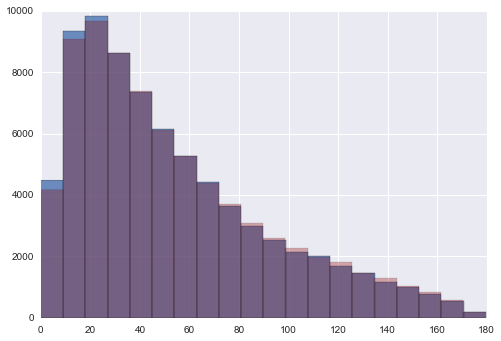

In [45]:
plt.hist(np.nan_to_num(obj_diff_deg), bins=20, alpha=0.8);
plt.hist(np.nan_to_num(calc_diff_deg), bins=20, alpha=0.3, color='darkred');

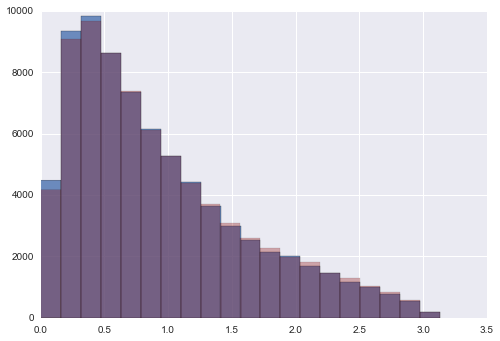

In [46]:
plt.hist(np.nan_to_num(obj_diff_rad), bins=20, alpha=0.8);
plt.hist(np.nan_to_num(calc_diff_rad), bins=20, alpha=0.3, color='darkred');

In [47]:
simple_calc_vs_obj_rad, simple_calc_vs_obj_deg = compare_normals(obj_simple_normals, calc_simple_normals)

In [48]:
complex_calc_vs_obj_rad, complex_calc_vs_obj_deg = compare_normals(obj_complex_normals, calc_complex_normals)

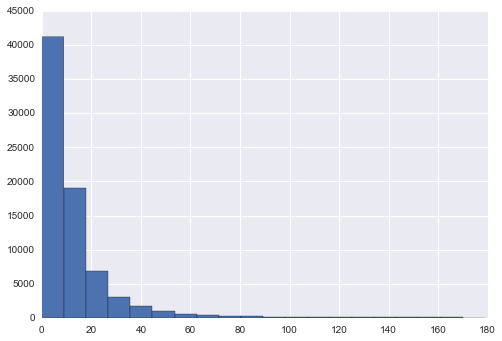

In [49]:
plt.hist(np.nan_to_num(simple_calc_vs_obj_deg), bins=20);

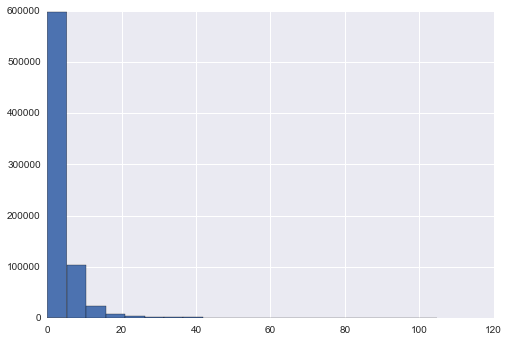

In [50]:
plt.hist(np.nan_to_num(complex_calc_vs_obj_deg), bins=20);

### updating voronoi function to take into account normals

In [ ]:
def find_voronoi_seeds(simple_vertices, complex_vertices):
    '''
    Finds those points on the complex mesh that correspoind best to the
    simple mesh while forcing a one-to-one mapping
    '''
    import numpy as np
    import scipy.spatial as spatial
    # make array for writing in final voronoi seed indices
    voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
    missing = np.where(voronoi_seed_idx==-1)[0].shape[0]
    mapping_single = np.zeros_like(voronoi_seed_idx)

    neighbours = 0
    col = 0

    while missing != 0:

        neighbours += 100
        # find nearest neighbours
        inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)
        # go through columns of nearest neighbours until unique mapping is
        # achieved, if not before end of neighbours, extend number of neighbours
        while col < neighbours:
            # find all missing voronoi seed indices
            missing_idx = np.where(voronoi_seed_idx==-1)[0]
            missing = missing_idx.shape[0]
            if missing == 0:
                break
            else:
                # for missing entries fill in next neighbour
                mapping_single[missing_idx]=np.copy(mapping[missing_idx,col])
                # find unique values in mapping_single
                unique, double_idx = np.unique(mapping_single, return_inverse = True)
                # empty voronoi seed index
                voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1
                # fill voronoi seed idx with unique values
                for u in range(unique.shape[0]):
                    # find the indices of this value in mapping
                    entries = np.where(double_idx==u)[0]
                    # set the first entry to the value
                    voronoi_seed_idx[entries[0]] = unique[u]
                # go to next column
                col += 1 
                
    return voronoi_seed_idx, inaccuracy

In [84]:
from bintrees import FastAVLTree
import scipy.spatial as spatial

In [52]:
tree = FastAVLTree()
# organisation will be key: mapping score, values: tuple(simple_vertex, candiate_complex_vertex)

In [88]:
complex_vertices = complex_v
simple_vertices = simple_v
neighbours = 100

In [89]:
inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)

In [123]:
simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in range(simple_vertices.shape[0])]).flatten()

In [94]:
candidate_idxs = mapping.flatten()

In [95]:
vertex_pairs = zip(simple_idxs, candidate_idxs)

In [118]:
simple_normals = calculate_normals(simple_vertices, simple_f)
complex_normals = calculate_normals(complex_vertices, complex_f)

In [189]:
_, diff_normals = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])

In [173]:
scores = inaccuracy.flatten() + diff_normals

In [174]:
tree_seq = zip(scores, vertex_pairs)

In [175]:
tree = FastAVLTree(tree_seq)

In [176]:
inaccuracy.flatten()

array([ 1.77701094,  1.77833458,  1.78485551, ...,  2.10294553,
        2.12555753,  2.12903435])

In [177]:
diff_normals

array([ 0.26341964,  0.27345084,  0.28022562, ...,  0.21498595,
        0.77541723,  1.04226541])

In [178]:
tree.pop_min()

(0.068743590254932693, (44945, 404362))

In [154]:
np.where(mapping[57500]==529557)

(array([2]),)

In [156]:
inaccuracy[57500][2]

0.21646827953304151

In [158]:
simple_normals[57500]

array([ 0.64585196, -0.39990079,  0.6503496 ])

In [159]:
complex_normals[529557]

array([ 0.64775829, -0.39786095,  0.64970445])

In [171]:
test_rad, test_deg =compare_normals(simple_normals[57500][np.newaxis, :], complex_normals[529557][np.newaxis,:])

In [187]:
inaccuracy[57500][2] + test_rad

array([ 0.21933381])

In [ ]:
def find_voronoi_seeds(simple_vertices, simple_faces, complex_vertices, complex_faces):
    '''
    Finds those points on the complex mesh that correspond best to the
    simple mesh (taking into accound euclidian distance and direction of normals)
    while forcing a one-to-one mapping
    '''
    from bintrees import FastAVLTree
    import scipy.spatial as spatial
    
    neighbours = 100
    
    # calculate normals for simple and complex vertices
    simple_normals = calculate_normals(simple_vertices, simple_faces)
    complex_normals = calculate_normals(complex_vertices, complex_faces)
    
    # find nearest neighbours of simple vertices on complex mesh using kdtree
    inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)
    
    # create tidy long-format lists
    simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in range(simple_vertices.shape[0])]).flatten()
    candidate_idxs = mapping.flatten()
    diff_euclid = inaccuray.flatten()
    
    # for each vertex pair calculate the angle between their normals
    _, diff_normals = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])
    
    # remove those pairs that have an angle > 90° and/or distance > 2 mm
    keep = np.unique(np.concatenate((np.where(diff_normals < 90)[0], np.where(diff_euclid < 2)[0])))
    diff_normals = diff_normals[keep]
    diff_euclid = diff_euclid[keep]
    simple_idxs = simple_idxs[keep]
    candidate_idxs = candidate_idxs[keep]
    
    # calculate scores for each vertex pair
    ###  weighting??  ####
    scores = diff_normals + diff_euclid
    
    # make a binary search tree from the scores and vertex pairs, 
    # organisation is key: score, values: tuple(simple_vertex, candiate_complex_vertex)
    tree = FastAVLTree(zip(scores, zip(simple_idxs, candidate_idxs)))
    
    


In [218]:
diff_normals = diff_normals[keep]
simple_idxs = simple_idxs[keep]
candidate_idxs = candidate_idxs[keep]

(array([  1.35533000e+05,   8.73234000e+05,   2.14197800e+06,
          2.94810000e+06,   1.00066300e+06,   2.63921000e+05,
          8.27320000e+04,   3.25220000e+04,   1.81130000e+04,
          1.34930000e+04,   1.50390000e+04,   1.58000000e+04,
          8.28400000e+03,   2.97400000e+03,   1.94400000e+03,
          1.96400000e+03,   8.43000000e+02,   8.98000000e+02,
          4.72000000e+02,   3.93000000e+02]),
 array([ 0.0100008 ,  0.48435804,  0.95871529,  1.43307253,  1.90742977,
         2.38178702,  2.85614426,  3.3305015 ,  3.80485875,  4.27921599,
         4.75357323,  5.22793047,  5.70228772,  6.17664496,  6.6510022 ,
         7.12535945,  7.59971669,  8.07407393,  8.54843118,  9.02278842,
         9.49714566]),
 <a list of 20 Patch objects>)

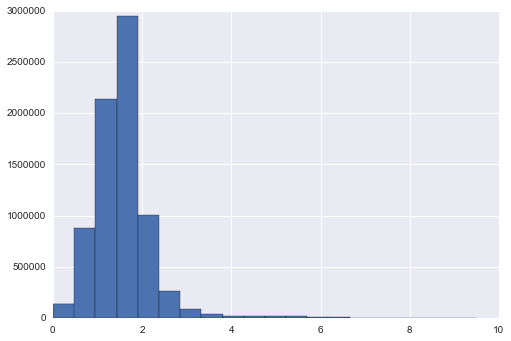

In [219]:
plt.hist(diff_euclid, bins=20)